In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib
from collections import OrderedDict
from math import ceil, floor
from operator import itemgetter
import matplotlib.pyplot as plt
from os.path import isfile

## Scrape Wikipedia Page

Yes, I could have also scraped the number of electors per state from the election pages. I decided to type them in, instead.

In [2]:
# list of state abbreviations
states = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL',
          'GA','HI','ID','IL','IN','IA','KS','KY','LA','ME',
          'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH',
          'NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',
          'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY', 'US']

def append_sum(ec, ignore_senate_ec_votes=False):
    subtract = 100 if ignore_senate_ec_votes else 0
    ec.append(sum(ec)-subtract)

def build_ec_votes_df(ignore_senate_ec_votes=False):
    ev = pd.DataFrame.from_dict(
         {1992: [9,  3,  8,  6,  54, 8,  8,  3,  3,  25,
                 13, 4,  4,  22, 12, 7,  6,  8,  9,  4,
                 10, 12, 18, 10, 7,  11, 3,  5,  4,  4,
                 15, 5,  33, 14, 3,  21, 8,  7,  23, 4,
                 8,  3,  11, 32, 5,  3,  13, 11, 5,  11, 3, 538],
          2004: [9,  3,  10, 6,  55, 9,  7,  3,  3,  27,
                 15, 4,  4,  21, 11, 7,  6,  8,  9,  4,
                 10, 12, 17, 10, 6,  11, 3,  5,  5,  4,
                 15, 5,  31, 15, 3,  20, 7,  7,  21, 4,
                 8,  3,  11, 34, 5,  3,  13, 11, 5,  10, 3, 538],
          2012: [9,  3,  11, 6,  55, 9,  7,  3,  3,  29,
                 16, 4,  4,  20, 11, 6,  6,  8,  8,  4,
                 10, 11, 16, 10, 6,  10, 3,  5,  6,  4,
                 14, 5,  29, 15, 3,  18, 7,  7,  20, 4,
                 9,  3,  11, 38, 6,  3,  13, 12, 5,  10, 3, 538],
          'states': states})
    ev.set_index(keys='states', inplace=True)
    if ignore_senate_ec_votes:
        for series in ev.columns:
            ev[series] -= 2
            ev[series][-1] -= 100
    ev[1996]=ev[1992]
    ev[2000]=ev[1992]
    ev[2016]=ev[2012]
    ev[2008]=ev[2004]
    ev.sort_index(axis=1, inplace=True)
    return ev

In [3]:
ec_votes = build_ec_votes_df()
ec_votes.tail()

,1992,1996,2000,2004,2008,2012,2016
states,,,,,,,
WA,11,11,11,11,11,12,12
WV,5,5,5,5,5,5,5
WI,11,11,11,10,10,10,10
WY,3,3,3,3,3,3,3
US,538,538,538,538,538,538,538


In [4]:
def get_headings(head_row, num_candidates):
    """
    Parse the table header row for the candidate names.
    head_row - the header row element containing cells with the candidate names
    num_candidates - the number of candidate columns in the "Results_by_state" table, including "Other"
    returns: list of length num_candidates with the candidate names
    """
    headings = []
    for cell in head_row.find_all('th', attrs={'colspan': '3'}):
        children = list(cell.children)
        if len(children) == 3:
            headings.append((children[0].strip(), children[2].strip()))
        else:
            headings.append((children[0], None))
    headings = headings[:num_candidates]
    headings.append(('Total', None))
    return headings

In [5]:
def get_table_rows(year, num_candidates):
    """
    Scrape the U.S. Presidential election Wikipedia page for the results by state. header rows of the 

    year - string containing 4-digit election year
    num_candidates - the number of candidate columns in the "Results_by_state" table, including "Other"
    returns: a tuple; first element is a list of length num_candidates with the candidate names; second
             element is a list of the table row elements needing to be parsed for the vote counts
    """
    page = BeautifulSoup(urllib.request.urlopen(
            'https://en.wikipedia.org/wiki/United_States_presidential_election,_'+str(year)).read(), "html.parser")
    header = page.find('span', id='Results_by_state').parent
    table_container = header.find_next_sibling('div')
    table = table_container.table
    if table is None:
        table_container = table_container.find_next_sibling('div')
        table = table_container.table
    head_row = table.find('tr')
    all_rows = list(table.find_all('tr'))
    vote_rows = all_rows[2:]
    return get_headings(head_row, num_candidates), vote_rows

In [6]:
def clean_and_convert(count_text):
    """
    Clean up vote count text, and return an actual number.
    count_text - the text from a vote count table cell
    returns: int representing number of votes (N/A or blank imply zero)
    """
    clean = count_text.strip().replace(',','').replace('.', '').replace('-','0').replace(
                'N/A', '0').replace('★', '').replace('–', '').replace('−', '')
    return int(clean) if len(clean) else 0

In [7]:
def file_for_year(year):
    return 'state-vote-data-{}.csv'.format(year)

In [8]:
def read_in_data(year, num_candidates, total_column):
    """
    Scrape the U.S. Presidential election Wikipedia for the given year. Requires a couple of numbers describing the
    shape of the table.

    year - string containing 4-digit election year
    num_candidates - the number of candidate columns in the "Results_by_state" table, including "Other"
    total_column - the column number that contains the total votes for each state/district, counting from zero
    returns: a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
             state total electoral college votes
    """
    filename = file_for_year(year)
    if isfile(filename):
        return pd.read_csv(filename, index_col=0)
    headings, vote_rows = get_table_rows(year, num_candidates)
    data = OrderedDict()
    columns_with_vote_counts = list(range(2, 3*num_candidates, 3))
    columns_with_vote_counts.append(total_column)
    abbr_column = total_column + 1
    vote_rows = list(zip(vote_rows, ['td'] * len(vote_rows)))
    vote_rows[-1] = (vote_rows[-1][0], 'th') # last row uses <th> instead of <td>
    for row, cell_type in vote_rows:
        cells = list(row.find_all(cell_type))
        try:
            abbr = cells[abbr_column].string.strip()
        except IndexError:
            print('{}, {}, {}'.format(year, abbr_column, cells))
            return None
        if len(abbr)==2 or len(abbr)==6:
            abbr = abbr[:2]
            data[abbr] = [clean_and_convert(cells[i].text) for i in columns_with_vote_counts]
    abbreviations  = []
    for h in headings:
        abbreviations.append(''.join([s[0] for s in h[0].split()]))
    vote_data = pd.DataFrame.from_dict(data, orient='index')
    vote_data.columns=abbreviations
    return vote_data

In [9]:
def check_totals(data, year):
    state_totals_valid = True
    for idx, state in data.iterrows():
        calculated_sum = state.iloc[:-1].sum()
        reported_sum = state['T']
        if calculated_sum != reported_sum:
            state_totals_valid = False
            print('Uh Oh! {} in year {} data had reported vote total {}, but I calculated {}!'.format(
                idx, year, reported_sum, calculated_sum))
            print(state)
            print()
    candidate_totals_valid = True
    trans = data.transpose()
    for idx, candidate in trans.iterrows():
        calculated_sum = candidate.iloc[:-1].sum()
        reported_sum = candidate['US']
        if calculated_sum != reported_sum:
            if candidate_totals_valid:
                print("For our purposes, errors in candidates' national totals can't affect the ")
                print("EC allocation calculations. Only errors in total votes cast in each state ")
                print("can affect the results.")
                print()
            candidate_totals_valid = False
            print('Uh Oh! {} in year {} data had reported vote total {}, but I calculated {}!'.format(
                idx, year, reported_sum, calculated_sum))
    if not candidate_totals_valid:
        print()
    return state_totals_valid and candidate_totals_valid

In [10]:
vote_data = OrderedDict()
shapes = [(1996, 6, 22), (2000, 8, 28), (2004, 7, 25), (2008, 7, 25), (2012, 5, 19), (2016, 6, 22)]

In [11]:
for year, num_candidates, total_column in shapes:
    vote_data[year] = read_in_data(year, num_candidates, total_column)
    if vote_data and check_totals(vote_data[year], year):
        print('{} Validated'.format(year))
        print('--------------')
        print(vote_data[year].loc['US'])
        print()

1996 Validated
--------------
BC    47400125
BD    39198755
RP     8085402
RN      685297
HB      485798
O       420024
T     96275401
Name: US, dtype: int64

2000 Validated
--------------
GWB     50456002
AG      50999897
RN       2882955
PB        448895
HB        384431
HP         98020
JH         83714
O          51186
T      105405100
Name: US, dtype: int64

2004 Validated
--------------
GWB     62040610
JK      59028444
RN        465151
MB        397265
MP        143630
DC        119859
O          99887
T      122294846
Name: US, dtype: int64

2008 Validated
--------------
BO     69498516
JM     59948323
RN       739034
BB       523715
CB       199750
CM       161797
O        242685
T     131313820
Name: US, dtype: int64

Uh Oh! US in year 2012 data had reported vote total 129085410, but I calculated 129085407!
BO     65915795
MR     60933504
GJ      1275971
JS       469627
O        490510
T     129085410
Name: US, dtype: int64

For our purposes, errors in candidates' national to

## Export data

In [12]:
def export_data(year, df):
    filename = 'state-vote-data-{}.csv'.format(year)
    df.to_csv(filename, sep=',')

for year, data in vote_data.items():
    export_data(year, data)

In [13]:
def partial_result_from_dict(data, category):
    """
    Prepare part of the final result from the given data, adding a category column to the index.
    data - a dict-like object mapping states/districts to counts with the partial result, 
           e.g., {'state abbr': int_count, ... }
    category - a string labelling the type of data, which is placed in a MultiIndex
    """
    result = pd.DataFrame.from_dict(data, orient='index')
    result.index.name = 'State'
    result['Category'] = category
    result.set_index('Category', append=True, inplace=True)
    return result

In [14]:
def fair_efficient(df, ev):
    """
    Compute a DataFrame representing fair and efficient allocation of Electoral College votes, and the
    number of wasted popular votes if fair and efficient allocation is used.

    df - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    ev - a Pandas Series, indexed by state/district, containing the number of electoral votes each state gets to allocate
    returns: a DataFrame multi-indexed by state/district and data category with candidate columns; data category = 'EC'
             gives Electoral College allocations ; data category = 'Wasted' gives wasted popular votes, i.e., votes that
             didn't end up counting towards an Elector
    """
    ec_votes = OrderedDict()
    wasted = OrderedDict()
    for idx, st in df.iterrows():
        if idx == 'US':
            continue
        c = OrderedDict(st.loc[:'O'])
        e = OrderedDict()
        r = {}
        E = ev[idx]
        V = st.loc['T']
        if V == 0:
            V = st.iloc[:-1].sum()
        for candidate, pop_votes in c.items():
            e[candidate] = floor(E * pop_votes / V)
            r[candidate] = ceil(pop_votes - V * e[candidate] / E)
        r = OrderedDict(sorted(r.items(), key=itemgetter(1), reverse=True))
        remainder = E - sum(e.values())
        for candidate in r.keys():
            if candidate != 'O': # not mappable to a single candidate
                e[candidate] += 1
                remainder -= 1
                r[candidate] = 0
                if remainder == 0:
                    break
        ec_votes[st.name] = e
        wasted[st.name] = r
    ec_votes = partial_result_from_dict(ec_votes, 'EC')
    wasted = partial_result_from_dict(wasted, 'Wasted')
    result = pd.concat([ec_votes, wasted])
    result.sort_index(level=['State', 'Category'], inplace=True)
    return result

In [15]:
def wta(df, ev):
    """
    Compute a DataFrame representing winner-take-all allocation (WTA) of Electoral College votes, and the
    number of wasted popular votes if WTA allocation is used.

    df - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    ev - a Pandas Series, indexed by state/district, containing the number of electoral votes each state gets to allocate
    returns: a DataFrame multi-indexed by state/district and data category with candidate columns; data category = 'EC'
             gives Electoral College allocations ; data category = 'Wasted' gives wasted popular votes, i.e., votes that
             didn't end up counting towards an Elector
    """
    ec_votes = OrderedDict()
    wasted = OrderedDict()
    for idx, st in df.iterrows():
        if idx == 'US':
            continue
        c = st.loc[:'O']
        e = pd.Series(0, c.index)
        r = c.copy()
        E = ev[idx]
        V = st.loc['T']
        if V == 0:
            V = st.iloc[:-1].sum()
        idxmax = c.idxmax()
        e[idxmax] = E
        r[idxmax] = 0
        r[idxmax] = c.max() - r.max() - 1
        ec_votes[st.name] = e
        wasted[st.name] = r
    ec_votes = partial_result_from_dict(ec_votes, 'EC')
    wasted = partial_result_from_dict(wasted, 'Wasted')
    result = pd.concat([ec_votes, wasted])
    result.sort_index(level=['State', 'Category'], inplace=True)
    return result

In [16]:
def calc_ec_allocations(methods, year, data, elec_votes):
    """
    Calculate a set of Electoral College allocations for comparison purposes.
    
    methods - an OrderedDict of functions for calculating allocations, with string keys used for labelling results
    year - 4-digit election year (int)
    data - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    elec_votes - a Pandas DataFrame, indexed by state/district, with columns for each presidential election year,
         containing each state's number of electoral college votes to allocate
    returns: a 2-tuple; the first element is an OrderedDict using the same keys as methods, with DataFrames containing
         the full state-by-state allocation results; the second elment is a summary DataFrame distilling all methods
         for the nation as a whole, i.e., tells you what the final EC vote counts come to
    """
    full_results = OrderedDict()
    cols = []
    total = data['T']['US']
    for key, fn in methods.items():
        result = fn(data, elec_votes[year])
        full_results[key] = result
        ec = result.loc[(slice(None), ['EC']),:].sum()
        cols.append(ec)
        wasted = result.loc[(slice(None), ['Wasted']),:].sum()
        cols.append(wasted)
        effgap = (wasted.sum() - 2 * wasted)/total
#         effgap.loc[ec == 0] = np.nan
        cols.append(effgap)
        summary = pd.concat(cols, axis=1)
    data_labels = ['Electors', 'Wasted Votes', 'Eff. Gap']
    col_labels = [(m, dl) for m in methods.keys() for dl in data_labels]
    summary.columns = pd.MultiIndex.from_tuples(col_labels)
    return full_results, summary

In [17]:
def print_ec_summary(year, data, elec_votes, show_state_data=False):
    """
    Print a useful summary of the calculations. By default, suppresses outputing the full dataset.

    year - 4-digit election year (int)
    data - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    elec_votes - a Pandas DataFrame, indexed by state/district, with columns for each presidential election year, containing
         each state's number of electoral college votes to allocate
    show_state_data - whether to show the full computed results by state/district; defaults to False
    """
    pd.options.display.max_rows = 102
    print(year)
    print('====')
    methods = OrderedDict([('WTA', wta), ('FnE', fair_efficient)])
    full_results, summary = calc_ec_allocations(methods, year, data, elec_votes)
    print(summary)
    print()
    for key in methods.keys():
        print('{} Total Wasted Votes: {}'.format(key, summary[key,'Wasted Votes'].sum()))
    print()
    if show_state_data:
        for key, result in full_results.items():
            print('{} Results by State:'.format(key))
            print(result)
            print()

Wasted votes are defined as votes for a candidate that didn't count towards allocating any electors.
Efficiency gap is a measure of unfair skew for a candidate. I invert the usual sign, and calculate it
as all other wasted votes minus a particular candates vote, all divided by the total votes cast. A
positive number, and indicates that the candidate had fewer wasted votes than the sum of the
other candidates' wasted votes. Negative means unfavorable. Magnitude matters. A fair allocation
of Electors should keep all efficiency gaps under 7% to 10%.

In [18]:
for year, data in vote_data.items():
    print_ec_summary(year, data, ec_votes, show_state_data = (year == 2016))

1996
====
        WTA                             FnE                       
   Electors Wasted Votes  Eff. Gap Electors Wasted Votes  Eff. Gap
BC      379     20694429  0.179459      267       808881  0.027152
BD      159     28295406  0.021558      224       905165  0.025152
HB        0       485798  0.599268        0       485798  0.033863
O         0       420024  0.600634        0       420024  0.035230
RN        0       685297  0.595124        1       499751  0.033573
RP        0      8085402  0.441396       46      1112185  0.020851

WTA Total Wasted Votes: 58666356
FnE Total Wasted Votes: 4231804

2000
====
         WTA                             FnE                       
    Electors Wasted Votes  Eff. Gap Electors Wasted Votes  Eff. Gap
AG       267     28317499  0.040316      262       863577  0.020549
GWB      271     28617825  0.034618      263       765498  0.022410
HB         0       384431  0.570330        0       384431  0.029641
HP         0        98020  0.575764  

In [19]:
def print_without_senate_ec_slots():
    ev = build_ec_votes_df(ignore_senate_ec_votes=True)
    for year, data in vote_data.items():
        print_ec_summary(year, data, ev, show_state_data = (year == 2016))

print('The following computes assuming the extra 2 "Senate" Electors are eliminated.')
print("from each state, i.e., it's thought experiment on the effect of the")
print('"Constitutional Gerrymander". In this case, 219 would be the requisite number')
print('of electors to win.')
print()
print_without_senate_ec_slots()

The following computes assuming the extra 2 "Senate" Electors are eliminated.
from each state, i.e., it's thought experiment on the effect of the
"Constitutional Gerrymander". In this case, 219 would be the requisite number
of electors to win.

1996
====
        WTA                             FnE                       
   Electors Wasted Votes  Eff. Gap Electors Wasted Votes  Eff. Gap
BC      315     20694429  0.179459      214      1685777  0.022455
BD      121     28295406  0.021558      187       658137  0.043803
HB        0       485798  0.599268        0       485798  0.047383
O         0       420024  0.600634        0       420024  0.048750
RN        0       685297  0.595124        1       492615  0.047242
RP        0      8085402  0.441396       34      1791095  0.020267

WTA Total Wasted Votes: 58666356
FnE Total Wasted Votes: 5533446

2000
====
         WTA                             FnE                       
    Electors Wasted Votes  Eff. Gap Electors Wasted Votes  Eff. 

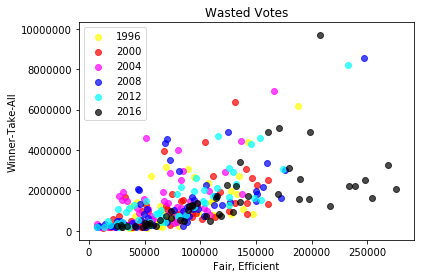

In [20]:
def plot_wasted():
    colors = {1996: 'yellow', 2000: 'red', 2004:'magenta', 2008:'blue', 2012:'cyan', 2016:'black'}
    plt.title('Wasted Votes')
    plt.xlabel("Fair, Efficient")
    plt.ylabel("Winner-Take-All")
    for year, data in vote_data.items():
        result_wta = wta(data, ec_votes[year])
        fe = fair_efficient(data, ec_votes[year])
        few = fe.loc[(slice(None), ['Wasted']),:].sum(axis=1)
        wtaw = result_wta.loc[(slice(None), ['Wasted']),:].sum(axis=1)
        plt.scatter(x=few, y=wtaw, color=colors[year], label=str(year), alpha=0.7)
    plt.legend()
    plt.ticklabel_format(style='plain')
plot_wasted()

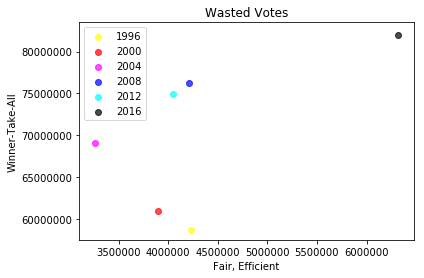

In [21]:
def plot_wasted_sum():
    colors = {1996: 'yellow', 2000: 'red', 2004:'magenta', 2008:'blue', 2012:'cyan', 2016:'black'}
    plt.title('Wasted Votes')
    plt.xlabel("Fair, Efficient")
    plt.ylabel("Winner-Take-All")
    for year, data in vote_data.items():
        result_wta = wta(data, ec_votes[year])
        fe = fair_efficient(data, ec_votes[year])
        few = fe.loc[(slice(None), ['Wasted']),:].sum(axis=1).sum()
        wtaw = result_wta.loc[(slice(None), ['Wasted']),:].sum(axis=1).sum()
        plt.scatter(x=few, y=wtaw, color=colors[year], label=str(year), alpha=0.7)
    plt.legend()
    plt.ticklabel_format(style='plain')
plot_wasted_sum()

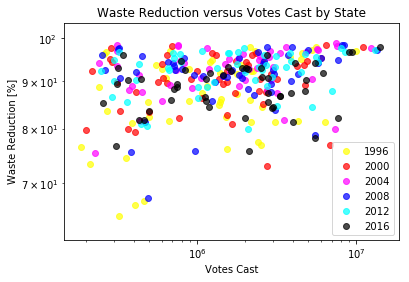

In [22]:
def plot_waste_reduction_versus_votes_cast(include_years=None):
    colors = {1996: 'yellow', 2000: 'red', 2004:'magenta', 2008:'blue', 2012:'cyan', 2016:'black'}
    plt.title('Waste Reduction versus Votes Cast by State')
    plt.xlabel("Votes Cast")
    plt.ylabel("Waste Reduction [%]")
    plt.xscale('log')
    plt.yscale('log')
    for year, data in vote_data.items():
        if include_years is None or year in include_years:
            result_wta = wta(data, ec_votes[year])
            fe = fair_efficient(data, ec_votes[year])
            few = fe.loc[(slice(None), ['Wasted']),:].sum(axis=1)
            wtaw = result_wta.loc[(slice(None), ['Wasted']),:].sum(axis=1)
            wr = (1.0 - few/wtaw) * 100.0
            votes = data['T'].drop(data.index[[51]])
            plt.scatter(x=votes, y=wr, color=colors[year], label=str(year), alpha=0.7)
    plt.legend()
#     plt.ticklabel_format(style='sci')
plot_waste_reduction_versus_votes_cast()

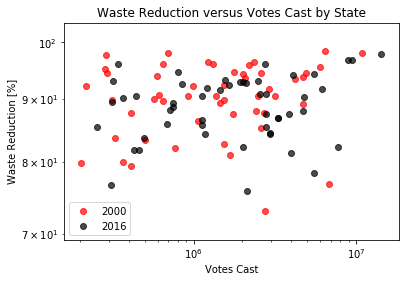

In [23]:
plot_waste_reduction_versus_votes_cast([2000, 2016])

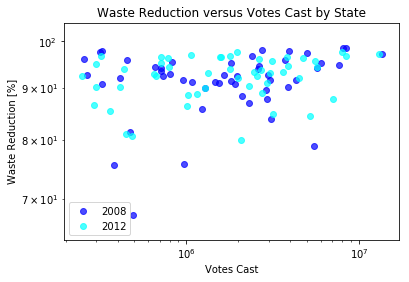

In [24]:
plot_waste_reduction_versus_votes_cast([2008, 2012])

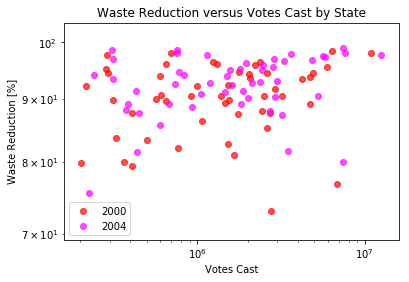

In [25]:
plot_waste_reduction_versus_votes_cast([2000, 2004])